In [83]:
import json
import itertools
from pathlib import Path
from pprint import pprint
from types import SimpleNamespace

import cv2
import geotiff
import rasterio
import shapely.geometry
import shapely.wkt
import rioxarray
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image, ImageDraw

In [84]:
MASK_FILE = Path("data/xBD/geotiffs/tier1/labels/palu-tsunami_00000166_post_disaster.json")

In [85]:
damage_to_label = {
    "no-damage": 0,
    "minor-damage": 1,
    "major-damage": 2,
    "destroyed": 3,
    "un-classified": 4,
}

In [86]:
with open(MASK_FILE, mode="r") as fp:
    labels_json = json.load(
        fp,
    )
polys_damages = [
    (shapely.wkt.loads(polygon["wkt"]), damage_to_label[polygon["properties"].get("subtype", "no-damage")])
    for polygon in labels_json["features"]["xy"]
]
polys_damages

[(<POLYGON ((31.66 989.544, 27.734 988.567, 30.572 980.283, 34.024 982.277, 35...>,
  3),
 (<POLYGON ((404.675 1022.957, 430.923 798.663, 551.955 815.105, 548.473 844.1...>,
  2),
 (<POLYGON ((231.777 1022.957, 237.762 962.256, 239.359 946.457, 241.521 923.0...>,
  2),
 (<POLYGON ((205.546 943.084, 239.359 946.457, 237.762 962.256, 221.418 961.47...>,
  0),
 (<POLYGON ((250.416 873.561, 287.136 877.784, 289.721 880.347, 287.672 899.55...>,
  3),
 (<POLYGON ((241.291 867.857, 249.84 786.744, 279.476 789.76, 272.275 871.314,...>,
  3),
 (<POLYGON ((168.119 922.731, 204.064 930.216, 199.189 958.206, 202.097 958.76...>,
  3),
 (<POLYGON ((160.531 1013.671, 163.604 1014.183, 165.397 1004.325, 189.508 100...>,
  3),
 (<POLYGON ((10.832 785.308, 40.311 785.034, 41.02 813.261, 21.446 813.686, 12...>,
  3),
 (<POLYGON ((153.997 651.174, 234.575 658.473, 239.45 664.566, 387.437 674.49,...>,
  2),
 (<POLYGON ((213.951 595.311, 221.107 595.496, 221.338 589.834, 234.512 590.52...>,
  2),
 (<POLYGON

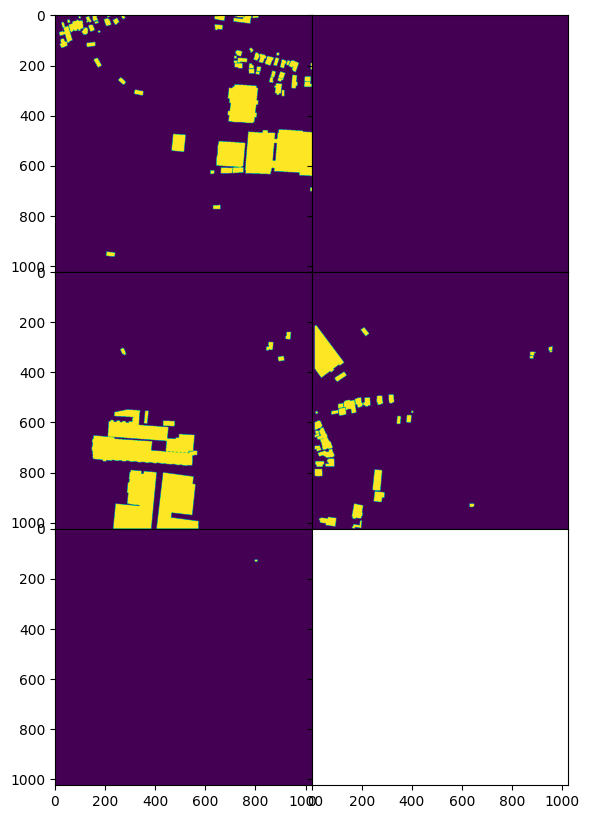

In [160]:
fig = plt.figure(figsize=(10, 10))

grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(3, 2),
    axes_pad=0,
)

key = lambda x: x[1]
grouped = {k: list(grouper) for k, grouper in itertools.groupby(sorted(polys_damages, key=key), key=key)}
rasterized = {
    k: np.clip(
        rasterio.features.rasterize([a for a, _ in group], out_shape=(1024, 1024), dtype=np.uint8), a_min=0, a_max=1
    )
    for k, group in grouped.items()
}

rasterized_layers = [rasterized.get(i, np.zeros((1024, 1024), dtype=np.uint8)) for i in range(5)]

for layer, ax in zip(rasterized_layers, grid):
    ax.imshow(layer)

In [154]:
aaa = np.stack(rasterized_layers)
print(aaa.shape)
np.savez_compressed("test", aaa)

(6, 1024, 1024)


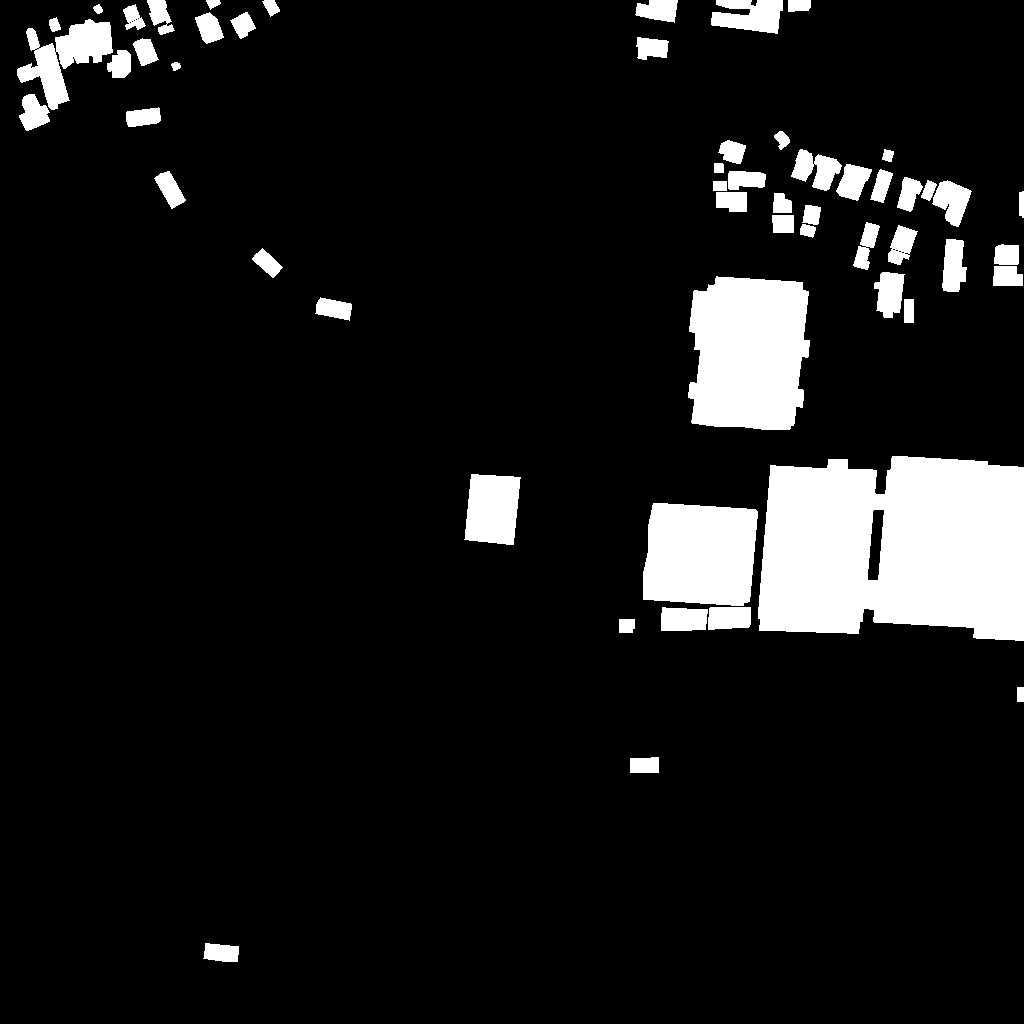

In [137]:
Image.fromarray(rasterized_layers[0] * 255)

In [161]:
def make_mask(labels_path: Path | str, img_size: tuple[int, int]) -> np.array:
    damage_to_label = {
        "no-damage": 0,
        "minor-damage": 1,
        "major-damage": 2,
        "destroyed": 3,
        "un-classified": 4,
    }

    with open(labels_path, mode="r") as fp:
        labels_json = json.load(fp)
    polys_damages = [
        (shapely.wkt.loads(polygon["wkt"]), damage_to_label[polygon["properties"].get("subtype", "no-damage")])
        for polygon in labels_json["features"]["xy"]
    ]
    key = lambda x: x[1]
    grouped = {k: list(grouper) for k, grouper in itertools.groupby(sorted(polys_damages, key=key), key=key)}
    rasterized = {
        k: np.clip(
            rasterio.features.rasterize([a for a, _ in group], out_shape=img_size, dtype=np.uint8), a_min=0, a_max=1
        )
        for k, group in grouped.items()
    }

    rasterized_layers = [rasterized.get(i, np.zeros(img_size, dtype=np.uint8)) for i in range(5)]
    return np.stack(rasterized_layers)

In [175]:
aaa = make_mask("data/xBD/geotiffs/tier1/labels/palu-tsunami_00000166_post_disaster.json", img_size=(1024, 1024))
(np.logical_or(aaa[3] == np.zeros(aaa[3].shape, dtype=np.uint8), aaa[3] == np.ones(aaa[3].shape, dtype=np.uint8))).all()

True